## Using the density maps to asign the local density to the galaxies
![HELP LOGO](https://avatars1.githubusercontent.com/u/7880370?s=100&v=4>)

In [1]:
import numpy as np

import os
from astropy.io import fits

from astropy import units as u
from astropy.coordinates import SkyCoord

import pprint
from scipy.special import erf
from scipy.integrate import simps, trapz
from scipy.stats.mstats import gmean

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline  

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

from matplotlib.colors import LinearSegmentedColormap

cdict = {'red': ((0., 0.8, 0.8),
                 (0.08, 0.8, 0.8),
                 (0.3, 0.0, 0.0),
                 (1, 1, 1)),
         'green': ((0., 1.0, 1.0),
                 (0.08, 0.8, 0.8),
                   (0.3, 0.0, 0.0),
                   (0.73, 0.0, 0.0),
                   (1, 0, 0)),
         'blue': ((0., 0.8, 0.8),
                 (0.08, 1, 1),
                  (0.45, 0.5, 0.5),
                  (0.65, 0.0, 0.0),
                  (1, 0, 0))}

my_cmap = LinearSegmentedColormap('my_colormap',cdict,120)
name_field = 'COSMOS'

In [2]:
loc = ''
hdulist = fits.open(loc+'cosmos_allz.fits')
img = hdulist[1].data
cols = hdulist[1].columns
hdulist.close()
help_id = img['help_id_1']

z_med = np.array(img['zm_eazy'])
z_low = np.array(img['l68_eazy'])
z_high = np.array(img['u68_eazy'])
ra = np.array(img['RA_2'])
dec = np.array(img['DEC_2'])
mag1 = np.array(img['m_vista_ks'])
mag2 = np.array(img['m_wircam_ks'])
mag3 = np.array(img['m_ukidss_k'])



print(np.min(dec), np.max(dec))



use = (z_med >= 0.01) & (z_high <= 3.5) & ( (mag1 < 24.0) | (mag2 < 24) | (mag3 < 24)) 

err = (z_high[use] - z_low[use])/2.
z_med = z_med[use]
ra = ra[use]
dec = dec[use]
help_id = help_id[use]

1.49861961169 2.91285978945


/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


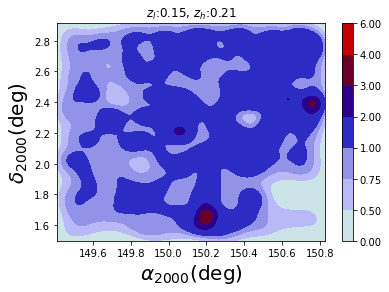

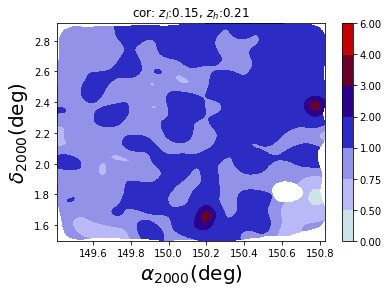

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:77: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 305 but corresponding boolean dimension is 304
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 305 but corresponding boolean dimension is 304


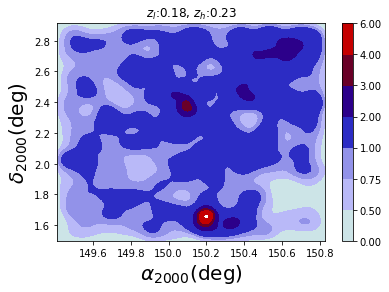

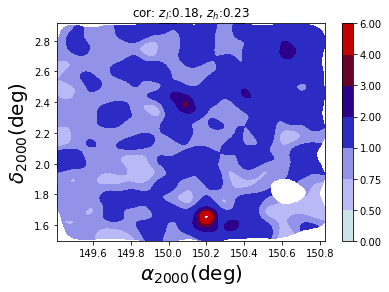

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:77: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 338 but corresponding boolean dimension is 337
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 338 but corresponding boolean dimension is 337


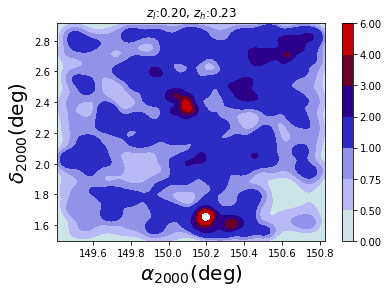

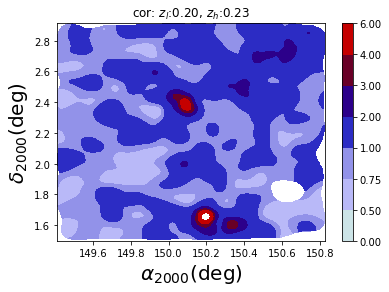

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:77: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 356 but corresponding boolean dimension is 355
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 356 but corresponding boolean dimension is 355


FileNotFoundError: [Errno 2] No such file or directory: 'map005numb002_COSMOS.cat'

In [3]:
id = np.arange(np.size(ra))+1

delta = np.zeros(np.size(id)) - 99
region = np.zeros(np.size(id)) - 99
percentiles = np.zeros(np.size(id)) - 99
id_test = np.zeros(np.size(id)) - 99


loc = ''

mat = np.loadtxt(loc+'z_slice_'+name_field+'.cat',dtype=float)
z_low = mat[:,0]
z_high = mat[:,1]

for g in range(2,np.size(z_low)):
  S_0 = np.loadtxt(loc+'map%03d'%g+'numb000_'+name_field+'.cat',dtype=float)
  x_edg = np.linspace(np.min(ra),np.max(ra),np.size(S_0[0,:])) 
  y_edg = np.linspace(np.min(dec),np.max(dec), np.size(S_0[:,0]) )


  x_p = np.zeros(np.size(x_edg) - 1)
  y_p = np.zeros(np.size(y_edg) - 1)
  for q in range(0,np.size(y_edg) - 1):
    y_p[q] = y_edg[q]/2 + y_edg[q+1]/2
  for q in range(0,np.size(x_edg) - 1):
    x_p[q] = x_edg[q]/2 + x_edg[q+1]/2 

  hight = (S_0/np.median(S_0))

  n_err = 4
  S_m = hight*0.0 +0.0
  for i in range(1,n_err+1):#5):
    name = loc+'map%03d'%g+'numb%03d'%i+'_'+name_field+'.cat'
    S_1 = np.loadtxt(name,dtype=float)  
    S_m = S_m + (S_1/np.mean(S_1))
  S_m = S_m/np.mean(S_m)
  bbb = (S_m >= 0.5)
  aaa = (S_m < 0.5)

  S_m = S_m/np.median(S_m[bbb])

  S_n = hight*0.0 +0.0
  S_n[bbb] = (S_0[bbb]/S_m[bbb])/np.median(S_0[bbb]/S_m[bbb])
  S_n[aaa] = S_n[aaa]*0.0 -99


  CS = plt.contourf(x_edg,y_edg,hight, levels = [0,0.5,0.75,1,2,3,4,6], cmap = my_cmap)
  plt.xlabel(r'$\alpha_{2000}(\rm deg)$', fontsize = 20)
  plt.ylabel(r'$\delta_{2000}(\rm deg)$', fontsize = 20)
  plt.title('$z_l$:'+str("%0.2f" % (z_low[g]))+', $z_h$:'+str("%0.2f" % (z_high[g])))
  #plt.xlim(150.8,149.3)
  plt.colorbar()
  plt.show()
  plt.close()

  
  CS = plt.contourf(x_edg,y_edg,S_n, levels = [0,0.5,0.75,1,2,3,4,6], cmap = my_cmap)

  plt.xlabel(r'$\alpha_{2000}(\rm deg)$', fontsize = 20)
  plt.ylabel(r'$\delta_{2000}(\rm deg)$', fontsize = 20)
  plt.title('cor: $z_l$:'+str("%0.2f" % (z_low[g]))+', $z_h$:'+str("%0.2f" % (z_high[g])))
  #plt.xlim(150.8,149.3)
  plt.colorbar()
  plt.savefig('use.pdf')
  plt.show()
  plt.close()


  use = (z_med >= z_low[g]) & (z_med < z_high[g])
  ra_orig_2 = ra[use]
  dec_orig_2 = dec[use]
  id_orig_2 = id[use]

  for m in range(0, np.size(id_orig_2)):
    x_use = ((ra_orig_2[m] - x_p)**2  == np.min((ra_orig_2[m] - x_p)**2))
    y_use = ((dec_orig_2[m] - y_p)**2  == np.min((dec_orig_2[m] - y_p)**2))
    if np.size(S_n[y_use,x_use]) == 1:
      delta[id_orig_2[m] -1] = np.max(np.append(S_n[y_use,x_use],delta[id_orig_2[m] -1]))

DAT = np.array([id,ra,dec,z_med,delta]).T
header = 'id  ra  dec  z  delta'
np.savetxt('all_galaxy_density_'+name_field+'.cat', DAT, delimiter=" ", fmt='%s',  header= header, newline='\n') 

In [18]:
hdu = fits.BinTableHDU.from_columns(\
     [fits.Column(name='help_id', array=help_id, format='A30'),
     fits.Column(name='RA', array=ra, format='F'),
     fits.Column(name='DEC', array=dec, format ='F'),
     fits.Column(name='z', array=z_med, format ='F'),
     fits.Column(name='delta', array=delta, format ='F') 
     ])
hdu.writeto('COSMOS_density_list.fits')

![HELP LOGO](https://avatars1.githubusercontent.com/u/7880370?s=75&v=4)

**Authors**: Steven Duivenvoorden 

For a full description of the database and how it is organised in to `dmu_products` please the top level [readme](../readme.md).

The Herschel Extragalactic Legacy Project, ([HELP](http://herschel.sussex.ac.uk/)), is a [European Commission Research Executive Agency](https://ec.europa.eu/info/departments/research-executive-agency_en)
funded project under the SP1-Cooperation, Collaborative project, Small or medium-scale focused research project, FP7-SPACE-2013-1 scheme, Grant Agreement Number 607254.

[Acknowledgements](http://herschel.sussex.ac.uk/acknowledgements)